In [1]:
!pip install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 29.8 MB/s eta 0:00:00


In [2]:
import os
import json
import shutil
import random
import cv2
from ultralytics import YOLO

# Paths
IMAGE_FOLDER = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images"
ANNOTATION_FOLDER = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/annotations"
OUTPUT_FOLDER = "/kaggle/working/yolo_plot_dataset"

# Create YOLO dataset structure
for split in ["train", "val"]:
    os.makedirs(os.path.join(OUTPUT_FOLDER, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_FOLDER, split, "labels"), exist_ok=True)

# Get all JSON files
json_files = [f for f in os.listdir(ANNOTATION_FOLDER) if f.endswith(".json")]

# Split dataset (80% train, 20% val)
random.shuffle(json_files)
split_index = int(0.8 * len(json_files))
train_files, val_files = json_files[:split_index], json_files[split_index:]

def process_json(json_path, image_folder, label_folder):
    """Extracts plot bounding box from JSON and saves as YOLO label format."""
    with open(json_path, "r") as f:
        data = json.load(f)

    # Extract plot bounding box
    if "plot-bb" not in data:
        return
    
    plot_bb = data["plot-bb"]
    x0, y0, width, height = plot_bb["x0"], plot_bb["y0"], plot_bb["width"], plot_bb["height"]

    # Normalize for YOLO format
    img_name = os.path.basename(json_path).replace(".json", ".jpg")
    img_path = os.path.join(IMAGE_FOLDER, img_name)
    
    if not os.path.exists(img_path):
        return

    img = cv2.imread(img_path)
    img_h, img_w, _ = img.shape

    x_center = (x0 + width / 2) / img_w
    y_center = (y0 + height / 2) / img_h
    w_norm = width / img_w
    h_norm = height / img_h

    # Create YOLO label file
    label_path = os.path.join(label_folder, img_name.replace(".jpg", ".txt"))
    with open(label_path, "w") as f:
        f.write(f"0 {x_center} {y_center} {w_norm} {h_norm}\n")

    # Copy image to dataset
    shutil.copy(img_path, os.path.join(image_folder, img_name))

# Process training and validation sets
for json_file in train_files:
    process_json(os.path.join(ANNOTATION_FOLDER, json_file),
                 os.path.join(OUTPUT_FOLDER, "train", "images"),
                 os.path.join(OUTPUT_FOLDER, "train", "labels"))

for json_file in val_files:
    process_json(os.path.join(ANNOTATION_FOLDER, json_file),
                 os.path.join(OUTPUT_FOLDER, "val", "images"),
                 os.path.join(OUTPUT_FOLDER, "val", "labels"))

print("✅ Dataset processing complete!")

# Create dataset.yaml file
dataset_yaml = f"""
train: {OUTPUT_FOLDER}/train/images
val: {OUTPUT_FOLDER}/val/images
nc: 1
names: ["plot"]
"""

with open(os.path.join(OUTPUT_FOLDER, "dataset.yaml"), "w") as f:
    f.write(dataset_yaml)

print("✅ dataset.yaml created!")

# Train YOLOv8 model
model = YOLO("yolov8m.pt")  # Use a suitable model size
model.train(data=os.path.join(OUTPUT_FOLDER, "dataset.yaml"),
            epochs=4, imgsz=640, batch=16, name="yolo_plot_detection")

print("🎯 Training complete! Model saved in 'runs/detect/yolo_plot_detection/'")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Dataset processing complete!
✅ dataset.yaml created!
Ultralytics 8.3.95 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/yolo_plot_dataset/dataset.yaml, epochs=4, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo_plot_detection2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=

100%|██████████| 755k/755k [00:00<00:00, 44.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

train: Scanning /kaggle/working/yolo_plot_dataset/train/labels... 10792 images, 0 backgrounds, 1 corrupt: 100%|██████████| 10792/10792 [00:08<00:00, 1274.37it/s]

train: WARNING ⚠️ /kaggle/working/yolo_plot_dataset/train/images/3ef41bbc82c3.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.2559      1.8027      3.5482       2.957]


train: New cache created: /kaggle/working/yolo_plot_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/yolo_plot_dataset/val/labels... 4047 images, 0 backgrounds, 1 corrupt: 100%|██████████| 4047/4047 [00:03<00:00, 1145.72it/s]

val: WARNING ⚠️ /kaggle/working/yolo_plot_dataset/val/images/3ef41bbc82c3.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.2559      1.8027      3.5482       2.957]


val: New cache created: /kaggle/working/yolo_plot_dataset/val/labels.cache
Plotting labels to runs/detect/yolo_plot_detection2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolo_plot_detection2
Starting training for 4 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/4      7.99G     0.2764     0.3324     0.9154         21        640: 100%|██████████| 675/675 [07:06<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:38<00:00,  3.27it/s]

                   all       4046       4046      0.999      0.997      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/4      8.01G     0.2314      0.213     0.8876         18        640: 100%|██████████| 675/675 [07:00<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:37<00:00,  3.40it/s]

                   all       4046       4046      0.992      0.983      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/4      8.01G     0.1989     0.1764     0.8754         20        640: 100%|██████████| 675/675 [06:58<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:37<00:00,  3.39it/s]

                   all       4046       4046      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/4      8.01G     0.1686     0.1463     0.8664         21        640: 100%|██████████| 675/675 [06:58<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:37<00:00,  3.42it/s]

                   all       4046       4046      0.999          1      0.995      0.995



4 epochs completed in 0.512 hours.
Optimizer stripped from runs/detect/yolo_plot_detection2/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/yolo_plot_detection2/weights/best.pt, 52.0MB

Validating runs/detect/yolo_plot_detection2/weights/best.pt...
Ultralytics 8.3.95 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:38<00:00,  3.26it/s]


                   all       4046       4046      0.999          1      0.995      0.995


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 6.6ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/yolo_plot_detection2
🎯 Training complete! Model saved in 'runs/detect/yolo_plot_detection/'



image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/0005e64fdc6e.jpg: 480x640 1 plot, 42.0ms
Speed: 2.0ms preprocess, 42.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


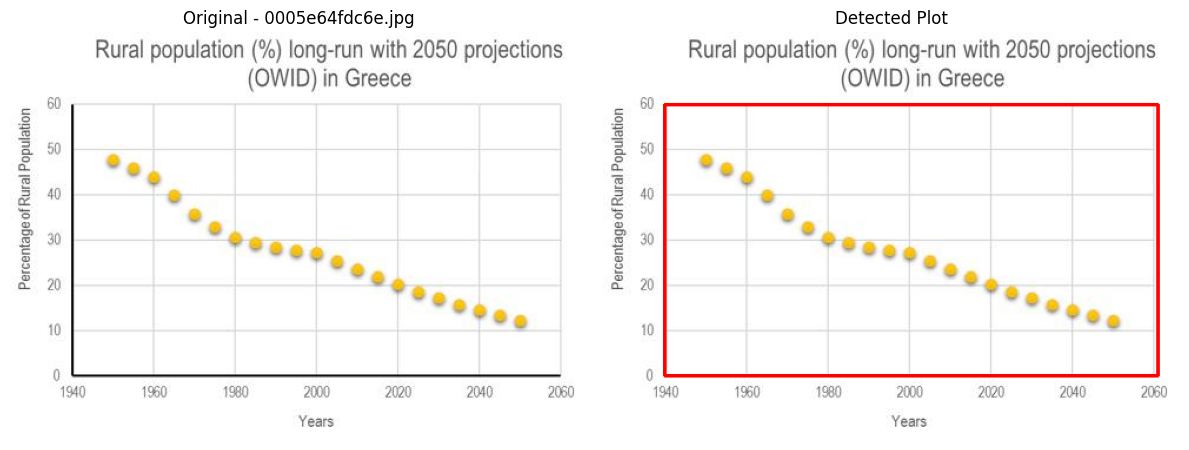


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/000631f33080.jpg: 384x640 1 plot, 44.6ms
Speed: 1.6ms preprocess, 44.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


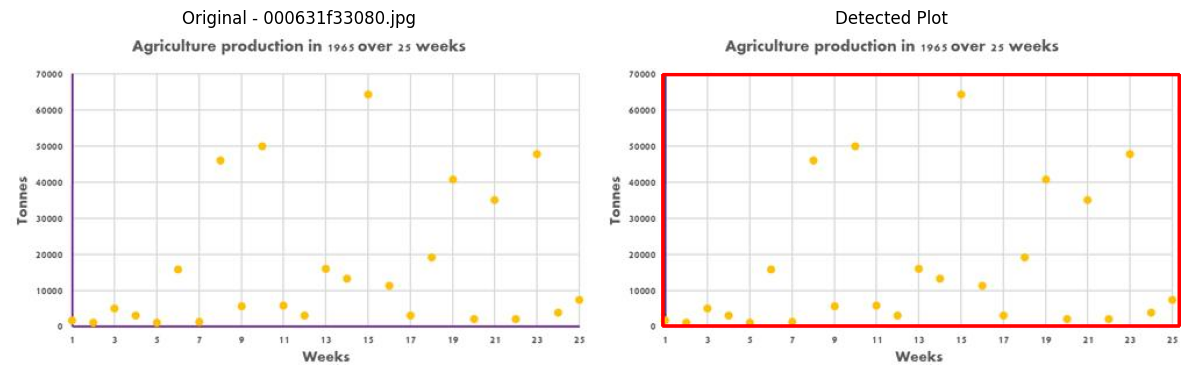


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/001f896fb543.jpg: 416x640 1 plot, 42.4ms
Speed: 1.7ms preprocess, 42.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


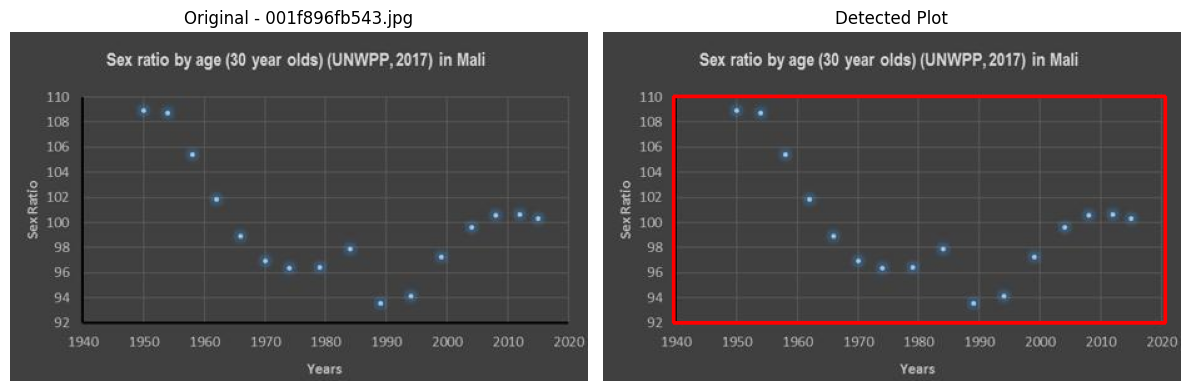


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/003448490d96.jpg: 352x640 1 plot, 48.2ms
Speed: 1.7ms preprocess, 48.2ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)


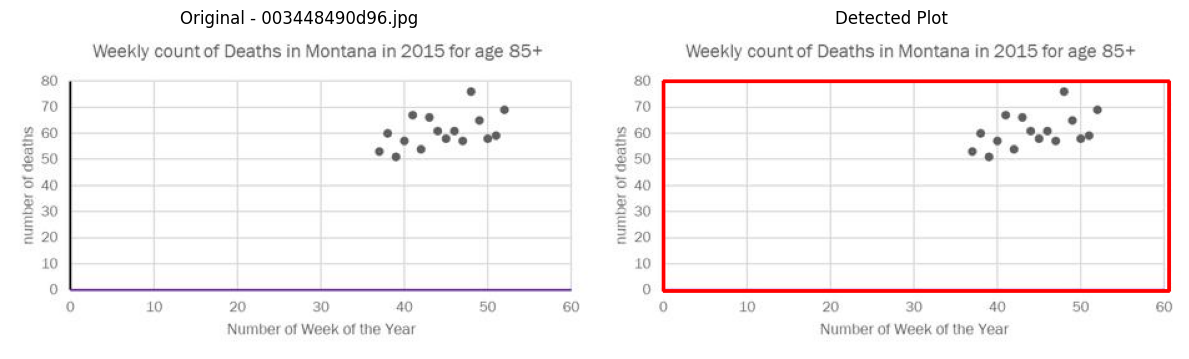


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/003645ee00b3.jpg: 384x640 1 plot, 12.9ms
Speed: 1.5ms preprocess, 12.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


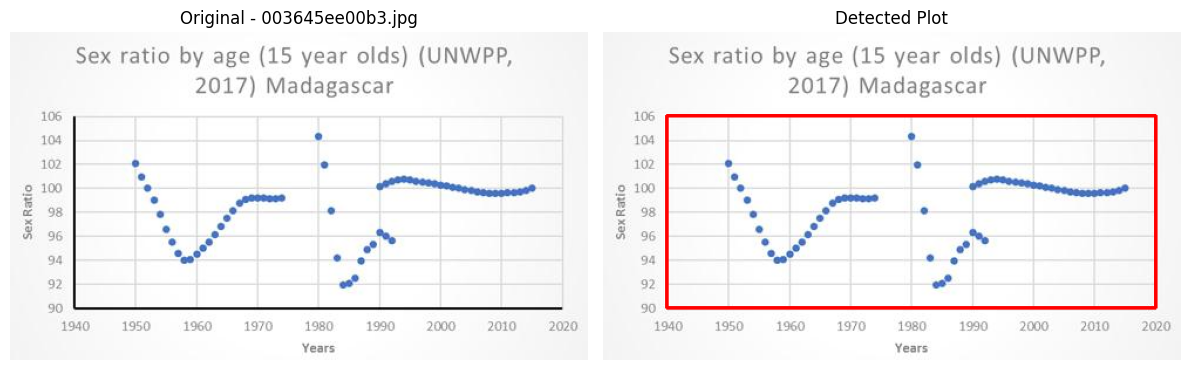

In [3]:
import cv2
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# Load trained YOLO model for plot detection
model = YOLO("/kaggle/working/runs/detect/yolo_plot_detection/weights/best.pt")

# Define the folder path containing images
folder_path = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images"

# Get the first 5 image file paths (assuming .jpg format)
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".jpg")])[:5]

# Loop over each image
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)

    # Run inference
    results = model(image_path)

    # Load the image with OpenCV
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a copy for drawing
    image_with_boxes = image.copy()

    # Extract bounding boxes
    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Display results
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title(f"Original - {image_file}")
    ax[0].axis("off")
    ax[1].imshow(image_with_boxes)
    ax[1].set_title("Detected Plot")
    ax[1].axis("off")
    plt.tight_layout()
    plt.show()
